In [1]:
import numpy as np
import tt
import bpx
from tt.amen import amen_solve
import matplotlib.pyplot as plt
import matplotlib
import copy
%matplotlib inline
matplotlib.rcParams.update({'font.size': 13})

## Error against $\ell$

In [3]:
with np.load('data/ms1d_unknownsol_n1.npz') as data:
    sols = data['dsols'][()]
    Ls = data['Ls'][()]
    epss_ms = sols.keys()
    
sols_exact_L = {}
for eps_ms in epss_ms:
    for i in range(len(sols[eps_ms])):
        sols[eps_ms][i] = tt.vector.from_list(sols[eps_ms][i])
    L = Ls[eps_ms][i]
    P = tt.kron(tt.matrix(np.ones((2, 1))), tt.eye(2, d=L))
    sol_ext = tt.vector.to_list(sols[eps_ms][-2])
    sol_ext = tt.vector.from_list([np.ones((1, 1, 1))] + sol_ext)
    #sols_exact_L[eps_ms] = (2*sols[eps_ms][-1] - tt.matvec(P, sol_ext).round(1e-14)).round(1e-12)
    
sols_exact = {}
errs_h1_exact = {}
for eps_ms in epss_ms:
    print 'eps', eps_ms
    P = tt.kron(tt.matrix(np.ones((2, 1))), tt.eye(2, d=Ls[eps_ms][-1]))
    sols_exact[eps_ms] = []
    errs_h1_exact[eps_ms] = []
    sol_ext = tt.vector.to_list(sols[eps_ms][-2])
    sol_ext = tt.vector.from_list([np.ones((1, 1, 1))] + sol_ext)
    sol_extr = (2*sols[eps_ms][-1] - tt.matvec(P, sol_ext).round(1e-14)).round(1e-12)
    for i in range(len(sols[eps_ms]))[::-1]:
        L = Ls[eps_ms][i]
        #print (sol_extr - sols[eps_ms][i]).norm() / (sols[eps_ms][i]).norm()
        sols_exact[eps_ms].append(sol_extr)
        errs_h1_exact[eps_ms].append((sol_extr - sols[eps_ms][i]).norm() / (sols[eps_ms][i]).norm())
        P = 0.5 * tt.kron(tt.matrix(np.ones((1, 2))), tt.eye(2, d=L))
        sol_extr = tt.matvec(P, sol_extr).round(1e-12)
        sol_extr = tt.sum(sol_extr, axis=0)
        #sols_exact[eps_ms].append([])
    sols_exact[eps_ms] = sols_exact[eps_ms][::-1]
    errs_h1_exact[eps_ms] = errs_h1_exact[eps_ms][::-1]
        
                                               

eps 0.00390625
eps 0.000244140625
eps 3.725290298461914e-09
eps 5.960464477539063e-08
eps 9.5367431640625e-07
eps 1.52587890625e-05


In [4]:
markers = ['>', 'o', 'v', 's', 'p', '*', 'D']

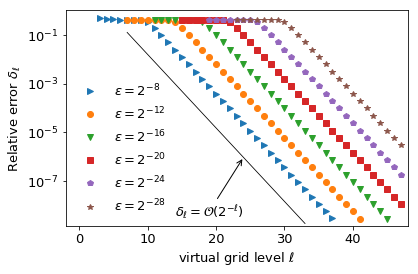

In [5]:
matplotlib.rcParams.update({'font.size': 13})

x = np.arange(7, 34)
y = 2.0 ** (-x + 4)
plt.semilogy(x, y, 'k', linewidth=0.8)


ind_end = [-12, -8, -4, -2, -2, -2]
for i, eps_ms in enumerate(np.sort(epss_ms)[::-1]):
    label = '$\\varepsilon = 2^{-' + str(int(np.abs(np.log2(eps_ms)))) + '}$'
    plt.semilogy(Ls[eps_ms][:ind_end[i]], errs_h1_exact[eps_ms][:ind_end[i]], '.', 
                 label=label, marker=markers[i]) 
    #print np.polyfit(Ls[eps_ms][12:-10], np.log2(errs_h1_exact[eps_ms][12:-10]), 1)

    
ind = 17
plt.annotate('$\\delta_\\ell=\mathcal{O}(2^{-\\ell})$', xy=(x[ind], y[ind]), 
             xytext=(x[ind]-10, 2.0**(np.log2(y[ind])-8)),
             arrowprops=dict(facecolor='black',arrowstyle='->', connectionstyle="arc3"))

plt.xlabel('virtual grid level $\\ell$')
#plt.ylabel('$|\cdot|_{H^1(\\Omega)}$ relative error $\\delta_\\ell$')
plt.ylabel('Relative error $\\delta_\\ell$')
plt.xlim([-2, 48])
plt.ylim([1.5*10**(-9), 1])
plt.legend(frameon=False)
plt.tight_layout()

#plt.savefig('figs/1d_err.pdf')

## Error against ranks

In [6]:
epss = 10 ** (-np.linspace(0, 10, 101))
const_eps = 2
eranks = {}
errs_h1 = {}
for eps_ms in epss_ms:
    eranks[eps_ms] = []
    errs_h1[eps_ms] = []
    for i in range(len(Ls[eps_ms])):
        sol_eps = copy.deepcopy(sols[eps_ms][i])
        sol_exact = copy.deepcopy(sols_exact[eps_ms][i])
        err_h1 = (sol_eps - sol_exact).norm() / (sol_exact).norm()
        for eps in list(epss)[::-1]:
            sol_eps = sol_eps.round(eps)
            err_h1_eps = (sol_exact - sol_eps).norm() / sol_exact.norm()
            if  err_h1_eps > const_eps * err_h1:
                eranks[eps_ms].append(sol_eps.erank)
                errs_h1[eps_ms].append(err_h1_eps)
                break

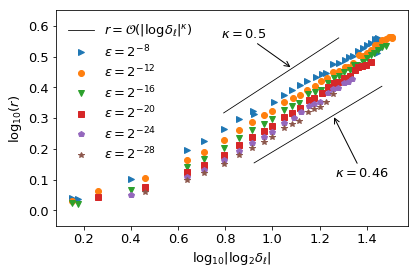

In [14]:
matplotlib.rcParams.update({'font.size': 13})

fig = plt.figure()
ax = fig.add_subplot(111)

kmin = 0.46
kmax = 0.5

x1 = np.sort(np.log10(-np.log2(errs_h1[2**(-8)]))[8:])
y1 = kmin*x1 - 0.27
plt.plot(x1, y1, 'k-', linewidth=0.8, label='$r=\\mathcal{O}(|\log \\delta_\\ell|^{\\kappa})$')
ax.annotate('$\\kappa={}$'.format(kmin), xy=(x1[9], y1[9]), xytext=(x1[9]+0.01, y1[9]-0.2),
            arrowprops=dict(facecolor='black',arrowstyle='->', connectionstyle="arc3"))

x2 = np.sort(np.log10(-np.log2(errs_h1[2**(-8)]))[5:-20])
y2 = kmax*x2 - 0.08
plt.plot(x2, y2, 'k-', linewidth=0.8)
ind = 6
ax.annotate('$\\kappa={}$'.format(kmax), xy=(x2[ind], y2[ind]), xytext=(x2[ind]-0.3, y2[ind]+0.1),
            arrowprops=dict(facecolor='black',arrowstyle='->', connectionstyle="arc3"))


for i, eps_ms in enumerate(np.sort(epss_ms)[::-1]):
    inds_perm = np.argsort(np.log10(-np.log2(errs_h1[eps_ms][:-1])))
    x = np.log10(-np.log2(errs_h1[eps_ms][:-1]))[inds_perm]
    y = np.log10(eranks[eps_ms][:-1])[inds_perm]
    label = '$\\varepsilon = 2^{-' + str(int(np.abs(np.log2(eps_ms)))) + '}$'
    plt.plot(x, y, '.', label=label, marker=markers[i]) 


#plt.plot(x, (1*x +0.9), 'k-', linewidth=0.8)


plt.xlabel('$\log_{10}|\log_2 \\delta_\\ell|$')
plt.ylabel('$\log_{10}(r)$')
#plt.xlim([-2.0, 1.75])
plt.ylim([-0.05, 0.65])
plt.legend(frameon=False, labelspacing=0.3)
plt.tight_layout()

#plt.savefig('figs/1d_rank.pdf')

## Error for homogenized

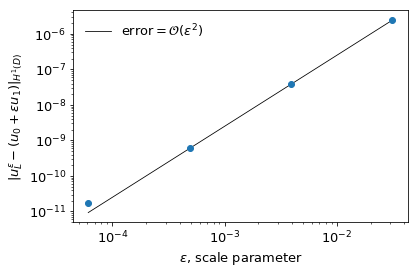

In [6]:
with np.load('data/ms1d_err_vs_eps.npz') as data:
    errs_eps = data['errs_eps'][()]
    epss_ms_hom = data['epss_ms'][()]

matplotlib.rcParams.update({'font.size': 13})

epss_ms_hom = np.array(epss_ms_hom)

p = np.polyfit(np.log10(epss_ms_hom), np.log10(errs_eps), 1)

x = epss_ms_hom
y = 10**(2*np.log10(epss_ms_hom) - 2)

plt.loglog(epss_ms_hom, 1./400* epss_ms_hom**2, 'k-', linewidth=0.8, label='error$=\mathcal{O}\\left(\\varepsilon^{2}\\right)$')
plt.loglog(epss_ms_hom, errs_eps, 'o')

plt.xlabel('$\\varepsilon$, scale parameter')
plt.ylabel('$|u^{\\varepsilon}_L - (u_0 + \\varepsilon u_1)|_{H^1(D)}$')
plt.legend(frameon=False)
plt.tight_layout()


plt.savefig('figs/1d_homerr.pdf')